In [1]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import numpy as np
import copy,os,glob
from mpl_toolkits.basemap import cm,addcyclic,Basemap, shiftgrid
% matplotlib inline

In [2]:
mesh=nc.Dataset('/ocean/xiaoxiny/research/NEMO-code/NEMOGCM/CONFIG/myANHA/EXP00/mesh_files/mesh_mask_rm1Canada.nc')

In [3]:
mbathy=mesh.variables['mbathy'][0,600,300]
gdept=mesh.variables['gdept'][0,:mbathy,600,300]
gdepw=mesh.variables['gdepw'][0,:mbathy,600,300]
e3t=mesh.variables['e3t'][0,:mbathy,600,300]
e3w=mesh.variables['e3w'][0,:mbathy+1,600,300]

In [11]:
ice=nc.Dataset('/ocean/xiaoxiny/research/data/forcing/Ice_nt/ANHA4-ENG3_icemod_y2003m09.nc')
ice=ice.variables['ileadfra'][600,300]
print (ice)

xd=nc.Dataset('/ocean/xiaoxiny/research/data/init_files/newzero_ANHA_Th_diss.nc')
xd=xd.variables['Th_diss'][0,:mbathy,600,300]

xp=nc.Dataset('/ocean/xiaoxiny/research/data/init_files/newzero_ANHA_Th_part.nc')
xp=xp.variables['Th_part'][0,:mbathy,600,300]

0.96


In [101]:
import pylab


S = np.zeros(gdept.shape)
k_ad = np.zeros(gdept.shape)

I = np.zeros(gdept.shape) # Ice signal
I_init=0.5+0.5*np.random.rand(I.shape[0])
#I_init[:] = 1.0
I=np.copy(I_init)


Q = 0.0267     #dpm/m^3
k_de = 0.5     #desorption constants

# time info
dt = 1./365/24/3600*10800
t = 0.0
tmax = 15  #run the model for 2 years

# initialize the data 
xd_=np.copy(xd)
xp_=np.copy(xp)


anew=np.zeros(xd.shape)
bnew=np.zeros(xd.shape)
cnew=np.zeros(xd.shape)

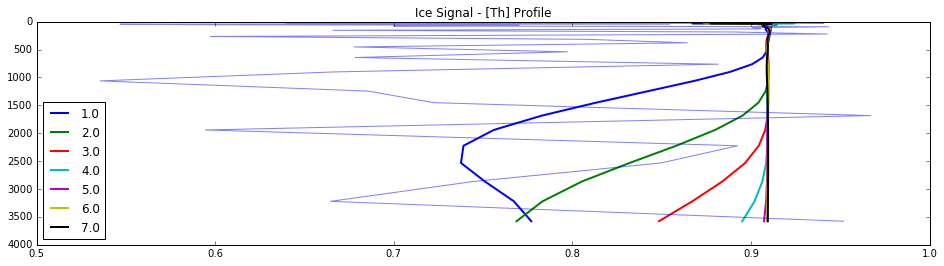

In [102]:
n=0

plt.figure(2, figsize = (16, 4))
plt.subplot()
while (t < tmax):               # loop through all dt on [0, tmax]
    I[:16]=ice-0.1*np.random.rand(1)
    # ice/sinking rate/adsorption constants
    S[:] = (-990*I[:]+1510)     
    k_ad[:] = -0.1*I[:]+0.2

    i=0                         # the surface BC.
    cnew[i] = I[i]   + (I[i-1]-I[i])*0.5*(S[i]+0)/e3w[i+1] * dt 
    
    i += 1
    while (i <= mbathy-1):     # loop through all depths
        

        cnew[i] = I[i] + (I[i-1]-I[i])*0.5*(S[i]+S[i-1])/e3w[i+1] * dt
        
        i += 1

    # store the updated solution
    I[:]   = cnew[:]

    t += dt

    n += 1
    if n%(2920*2)==0:

        # final dissolved and particulate
        plt.plot(I, gdept,lw=2,label= n/2920/2)

plt.plot(I_init, gdept, alpha=0.5)
plt.legend(loc=0)

    
# label and scale plots
#pylab.figure(2, figsize = (16, 8))
#pylab.xlim([0,0.6])
#pylab.subplot(212)
plt.title('Ice Signal - [Th] Profile')

plt.gca().invert_yaxis()


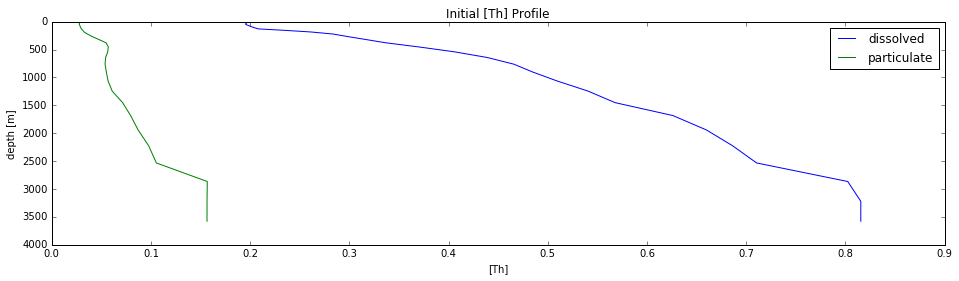

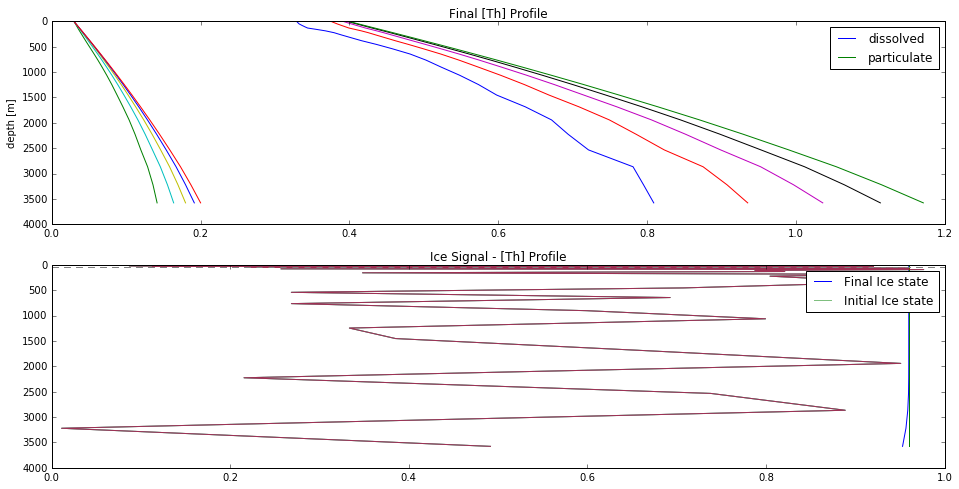

In [15]:
n=0
while (t < tmax):               # loop through all dt on [0, tmax]
    I[:16]=ice               # ice/sinking rate/adsorption constants
    S[:] = (-990*I[:]+1510)     
    k_ad[:] = -0.1*I[:]+0.2

    i=0                         # the surface BC.
    anew[i] = xd_[i] + (Q - k_ad[i]*xd_[i] + k_de*xp_[i]) * dt
    bnew[i] = 0.03#xp_[i] + (-S[i]*xp_[i]/e3w[i+1] + k_ad[i]*xd_[i] - k_de*xp_[i]) * dt
    cnew[i] = I[i]   + (I[i-1]-I[i])*0.5*(S[i]+0)/e3w[i+1] * dt 
    
    i += 1
    while (i <= mbathy-1):     # loop through all depths
        
        # forward difference
        anew[i] = xd_[i] + (Q - k_ad[i]*xd_[i] + k_de*xp_[i]) * dt

        bnew[i] = xp_[i] + ((S[i-1]*xp_[i-1]-S[i]*xp_[i])/e3w[i+1] 
                  + k_ad[i]*xd_[i] - k_de*xp_[i]) * dt
        
        cnew[i] = I[i] + (I[i-1]-I[i])*0.5*(S[i]+S[i-1])/e3w[i+1] * dt
        
        i += 1

    # store the updated solution
    xd_[:] = anew[:]
    xp_[:] = bnew[:]
    I[:]   = cnew[:]

    t += dt

    n += 1
    if n%(2920*10)==0:

        # final dissolved and particulate
        pylab.figure(2, figsize = (16, 8))
        pylab.subplot(211)
        pylab.plot(xd_, gdept)
        pylab.plot(xp_, gdept)
        pylab.subplot(212)
        pylab.plot(I, gdept)
        pylab.plot(I_init, gdept,alpha=0.5)
        pylab.legend(['Final Ice state', 'Initial Ice state'])
        pylab.axhline(y=gdept[16],color='grey',ls='--')
    

# initial dissolved and particulate
pylab.figure(1, figsize = (16, 4))  
pylab.plot(xd, gdept)
pylab.plot(xp, gdept)
    
# label and scale plots
pylab.figure(2, figsize = (16, 8))
pylab.subplot(211)
pylab.ylabel('depth [m]')
pylab.title('Final [Th] Profile')
pylab.legend(['dissolved', 'particulate'])
pylab.gca().invert_yaxis()
#pylab.xlim([0,0.6])
pylab.subplot(212)
pylab.title('Ice Signal - [Th] Profile')
pylab.gca().invert_yaxis()


pylab.figure(1, figsize = (16, 4))
pylab.gca().invert_yaxis()
pylab.title('Initial [Th] Profile')
pylab.legend(['dissolved', 'particulate'])
pylab.ylabel('depth [m]')
pylab.xlabel('[Th]')

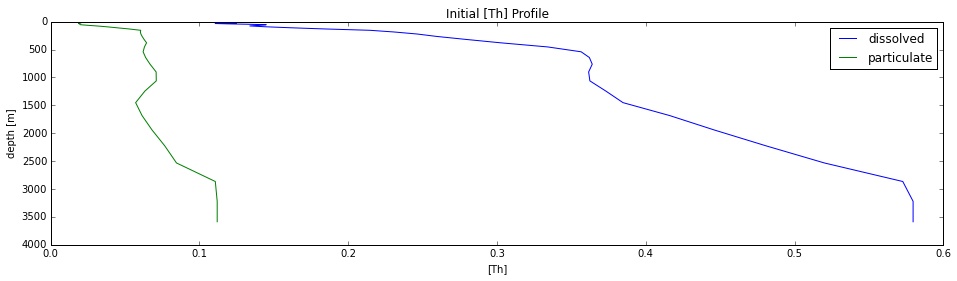

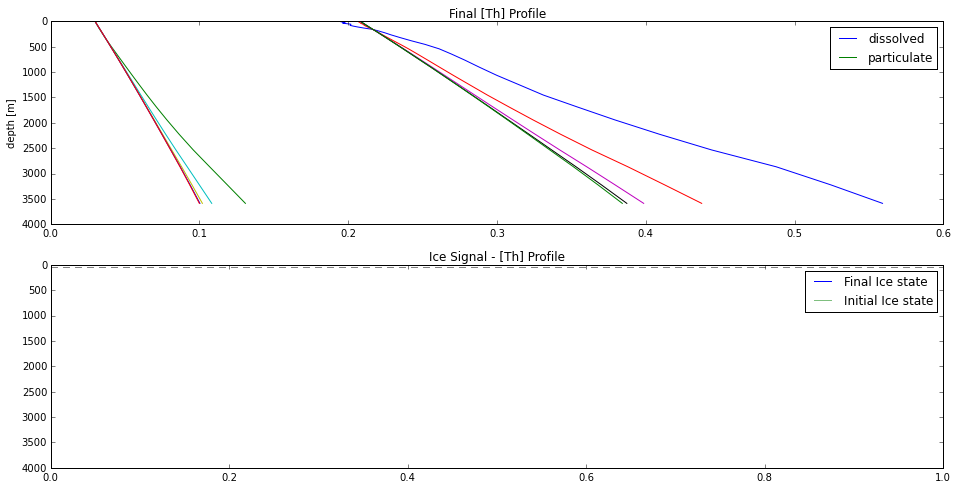

In [39]:
# 0 ice region

ps. xp is doing righ but xd is not.

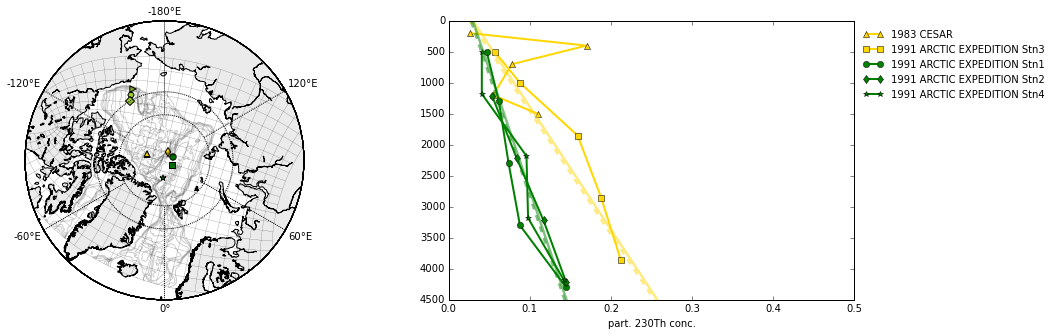

In [7]:
# trying to simulate the yellow line below
from IPython.display import Image
Image(filename='/ocean/xiaoxiny/research/writings/thesis_part1/figure/partTh_vertical.png') 

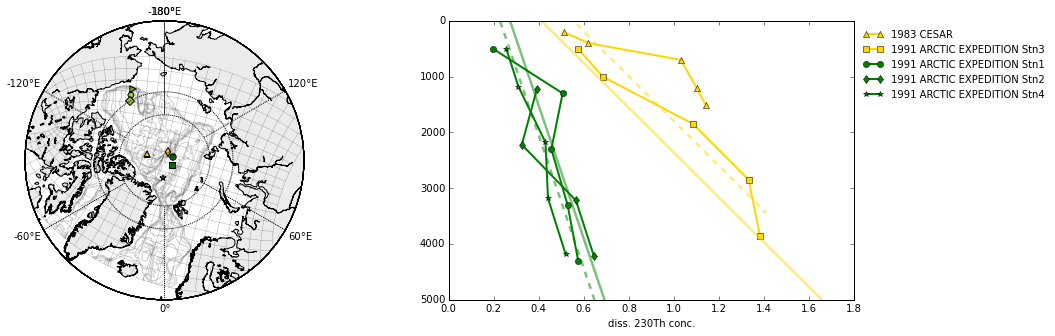

In [8]:
# trying to simulate the yellow line below
from IPython.display import Image
Image(filename='/ocean/xiaoxiny/research/writings/thesis_part1/figure/dissTh_vertical.png') 